In [1]:
import io
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tf.get_logger().setLevel("ERROR")

from tensorflow import keras
from keras import layers

import sklearn.neighbors as sk_neighbors
import sklearn.model_selection as sk_model

import numpy as np
import pandas as pd

from skimage import filters

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import sklearn

Training dataset: 5994
Test dataset: 5794


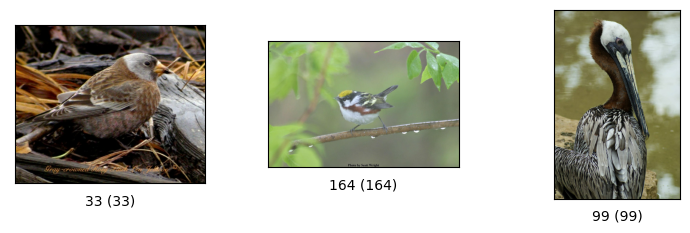

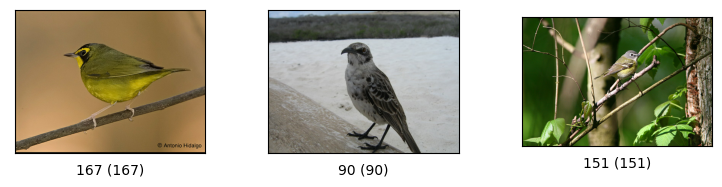

In [2]:
# Fetch dataset
(train_ds_original, test_ds_original), ds_info = tfds.load(
    "caltech_birds2011", 
    split=["train", "test"], 
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# Display dataset
print("Training dataset: {0}".format(len(train_ds_original)))
print("Test dataset: {0}".format(len(test_ds_original)))

fig = tfds.show_examples(train_ds_original.take(3), ds_info, image_key="image")
fig = tfds.show_examples(test_ds_original.take(3), ds_info, image_key="image")

In [4]:
# Settings
num_classes = 4
# num_classes = 200

num_images = 100

batch_size  = 16

img_size = 400
# img_size = 300
img_width   = img_size
img_height  = img_size

filter_labels = lambda image, label: label < num_classes

cnts = dict()
def filter_num(image, label):
    global cnts
    
    l = label.ref()
    if cnts[l] == None:
        cnts[l] = 0
    
    if cnts[l] < num_images:
        cnts[l] += 1
        return True
    
    return False
    

def resize_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    image = tf.image.resize_with_crop_or_pad(
        image, img_height, img_width
    )
    
    return image, label

def augment_images(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_saturation(image, 0.2, 3)
    image = tf.image.random_hue(image, 0.04)

    return image, label

# Prepear dataset
train_ds = (
    train_ds_original
    .filter(filter_labels)
    .filter(filter_num)
    .map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds_original
    .filter(filter_labels)
    .map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

fig = tfds.show_examples(train_ds.take(3), ds_info, image_key="image")
fig = tfds.show_examples(test_ds.take(3), ds_info, image_key="image")

train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

<class 'tensorflow.python.framework.ops.Tensor'>


AttributeError: in user code:

    File "/tmp/ipykernel_424328/448528874.py", line 22, in filter_num  *
        print(label.numpy())

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [ ]:
# Setup model
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation=None),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)),
])

# Summarize model
model.summary()

In [ ]:
# Prepear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletHardLoss(margin=1.4),
)

# Train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
)

In [ ]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ["loss", "val_loss"]].plot()

In [ ]:
# Test network
test_dataset = train_ds

results = model.predict(test_dataset)

time_sufix = datetime.now().strftime("%H:%M:%S")
np.savetxt("output/vecs-" + time_sufix + ".tsv", results, delimiter="\t")

out_m = io.open("output/meta-" + time_sufix + ".tsv", "w", encoding="utf-8")
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

In [ ]:
# Extract embiddings
def get_embeddings_and_labels(dataset):
    embaddings = model.predict(dataset)
    labels = np.concatenate([y.numpy() for x, y in dataset])
    assert embaddings.shape[0] == labels.shape[0]
    return embaddings, labels

train_embeddings, train_labels = get_embeddings_and_labels(train_ds)
val_embeddings, val_labels = get_embeddings_and_labels(test_ds)

In [ ]:
# Train KNN
knn_finder = sk_model.GridSearchCV(
    sk_neighbors.KNeighborsClassifier(), 
    param_grid={
        "n_neighbors": [1,2,3,4,5,6,7], 
        "weights": ["uniform", "distance"],
    },
    n_jobs=-1,
)

_ = knn_finder.fit(train_embeddings, train_labels)

In [ ]:
# Get training and validation acuuracy
knn_train_score = knn_finder.best_estimator_.score(train_embeddings, train_labels)
knn_val_score = knn_finder.best_estimator_.score(val_embeddings, val_labels)

print("Training:   {:.2f}%".format(knn_train_score * 100))
print("Validation: {:.2f}%".format(knn_val_score * 100))
print()
print("Guessing:   {:.2f}%".format(100/num_classes))
print("Improvemnt: {:.2f}".format(knn_val_score / (1/num_classes)))

In [ ]:
# Extract embadings
def embading_distances(embeddings, labels, samples):
    dist = tf.keras.metrics.MSE
    
    all_classes = np.unique(labels)

    pos_dists = []
    for i in tqdm(range(samples)):
        idx = np.random.choice(all_classes)
        possible_idxs = np.where(labels == idx)[0]
        choose_idx = np.random.choice(possible_idxs, size=2)

        d = dist(embeddings[choose_idx[0]], embeddings[choose_idx[1]])
        pos_dists.append(d)

    neg_dists = []
    for i in tqdm(range(samples)):
        idx = np.random.choice(all_classes)
        other_idxs = np.where(labels != idx)[0]
        choose_idx = np.random.choice(other_idxs, size=1)

        d = dist(embeddings[idx], embeddings[choose_idx[0]])
        neg_dists.append(d)
        
    pos_dists, neg_dists = sklearn.utils.shuffle(pos_dists, neg_dists)
    return pos_dists, neg_dists


num_samples = 2*10e2

train_pos_dists, train_neg_dists = embading_distances(train_embeddings, train_labels, samples=int(num_samples))
val_pos_dists, val_neg_dists = embading_distances(val_embeddings, val_labels, samples=int(num_samples))

In [ ]:
# Threshold
val_thresh = filters.threshold_otsu(np.concatenate([val_pos_dists, val_neg_dists]))
train_thresh = filters.threshold_otsu(np.concatenate([train_pos_dists, train_neg_dists]))

print(f'Threshold for train set: {train_thresh:0.5f} Threshold for test set: {val_thresh:0.5f} \t Validation threshold {(np.abs(train_thresh - val_thresh) / train_thresh)*100:0.2f}%')

In [ ]:
# Evaluate model
train_loss = model.evaluate(train_ds)
val_loss = model.evaluate(test_ds)

print(f'Loss | Train: {train_loss:0.4f} \t Validation: {val_loss:0.4f}')

In [ ]:
fig, ax = plt.subplots(figsize=(24, 4))

sns.distplot(train_pos_dists, label='Positive distances (train)')
sns.distplot(train_neg_dists, label='Negative distances (train)')

ax.vlines(train_thresh, 0, 1100, color='r', linestyle='--', label='Threshold')
ax.set_title('Validation distance distribution')

ax.set_xlabel('L2 distance', fontsize=16)
ax.legend();

plt.show()

fig, ax = plt.subplots(figsize=(24, 4))

sns.distplot(val_pos_dists, label='Positive distances (validation)')
sns.distplot(val_neg_dists, label='Negative distances (validation)')

ax.vlines(train_thresh, 0, 800, color='r', linestyle='--', label='Threshold')
ax.vlines(val_thresh, 0, 800, color='g', linestyle='--', label='Perfect threshold for validation set')

ax.set_xlabel('L2 distance', fontsize=16)
ax.legend()
ax.set_title('Validation distance distribution')

plt.show()